In [1]:
import numpy as np
from env.map2d import *
from modules.bayesfilter import *
import gym

In [2]:
def congregate_policy(bel,env,epilson=0.5):
    controls = []
    locs = np.argwhere(bel==bel.max(-1).reshape(bel.shape[0],-1,1))
    ret = defaultdict(list)
    for i in locs:
        ret[tuple(i[:2])].append(i[-1])
    for i in range(bel.shape[0]):
        maxlocs = [np.random.choice(ret[(i,j)]) for j in range(bel.shape[0])]
        avgloc = np.mean([env.translateLoc(x) for x in maxlocs],0)
        target = np.subtract(avgloc,env.translateLoc(maxlocs[i])).astype(int).clip(-1,1)
        controls.append(np.argwhere((env.actions==np.flip(target)).all(-1)).item())
    return controls

def random_ppolicy(bel,env):
    controls = []
    for i in range(env.n_agents):
        controls.append(np.random.choice(env.control_space))
    return controls

class Congregation(DecMap2d):
    def __init__(self,h,w,n_features=2,n_agents=1,_range=1):
        super().__init__(h,w,n_features,n_agents,_range)
        self.horizon = 30
    def reset(self):
        self.t = 0
        return super().reset()
    def step(self,action):
        self.t+=1
        obs = super().step(action)
        reward = 0
        for src in self.locs:
            for dest in self.locs:
                reward += self.within_range(src,dest,1)
        done = self.t == self.horizon
        return obs, reward, done, {}

In [3]:
from scipy.stats import wasserstein_distance,entropy

def compute_WDc(env,agent):
    H = 0
    target = np.zeros(shape = (env.n_agents,env.N))
    target[np.arange(env.n_agents),env.locs.tolist()] = 1
    for bel in agent.bel:
        for u,v in zip(bel,target):
            H += wasserstein_distance(u, v)
    return H

from collections import defaultdict
def run(seed,policy,n_rounds=1, _range=1):
    np.random.seed(seed)
    score = defaultdict(list)
    h = 10
    w = 10
    env = Congregation(h,w,n_agents=5,_range=_range)
    z = env.reset()
    agent = DecMABayesFilter(env)
    while True:
        u = policy(agent.bel,env)
        agent.control_update(u+[-1])
        z, reward, done,_  = env.step(u)
        agent.measurement_update(z)
        for i in range(n_rounds):
            agent.belief_sharing()
        score['reward'].append(reward)
        score['WD_cum'].append(compute_WDc(env,agent))        
        if done:
            break
    return score

In [4]:
scores = defaultdict(dict)
for seed in range(100):
    for i in [0,1,5]:
        out = run(seed,congregate_policy,i)
        for k,v in out.items():
            ret = scores['h'+str(i)].get(k,[])
            ret.append(v)
            scores['h'+str(i)][k] = ret
    for i in [0,1,5]:
        out = run(seed,random_ppolicy,i)
        for k,v in out.items():
            ret = scores['r'+str(i)].get(k,[])
            ret.append(v)
            scores['r'+str(i)][k] = ret
    out = run(seed,congregate_policy,0,_range=10)
    for k,v in out.items():
        ret = scores['f0'].get(k,[])
        ret.append(v)
        scores['f0'][k] = ret

<>:31: DeprecationWarning: invalid escape sequence \m


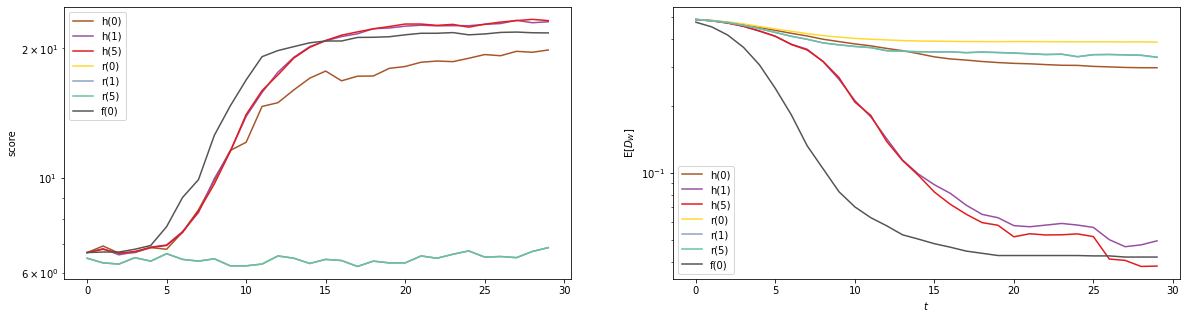

In [5]:
from matplotlib.cm import get_cmap
plt.figure(figsize=(20,5))
plt.subplot(121)
cmaps = ['Set1', 'Set2', 'binary']
for key in ['reward']:
    for i, agent in enumerate(scores.keys()):
        x = np.mean(scores[agent][key],0)
        if agent[0]=='h':
            cmap = get_cmap(cmaps[0])
        elif agent[0]=='r':
            cmap = get_cmap(cmaps[1])
        else:
            cmap = get_cmap(cmaps[2])
        plt.plot(x, color=cmap(((2-i)%3)/3), label=agent[0]+f"({agent[1]})")
plt.yscale('log')
plt.ylabel("score")
plt.legend()
plt.subplot(122)
cmaps = ['Set1', 'Set2', 'binary']
for key in ['WD_cum']:
    for i, agent in enumerate(scores.keys()):
        x = np.mean(scores[agent][key],0)
        if agent[0]=='h':
            cmap = get_cmap(cmaps[0])
        elif agent[0]=='r':
            cmap = get_cmap(cmaps[1])
        else:
            cmap = get_cmap(cmaps[2])
        plt.plot(x, color=cmap(((2-i)%3)/3), label=agent[0]+f"({agent[1]})")
plt.yscale('log')
plt.ylabel("$\mathrm{E}[D_W]$")
plt.xlabel("$t$")
plt.legend()